In [ ]:
# Compute sea ice volume

import datetime
import numpy as np
import xarray as xr
import netCDF4 as nc4
import matplotlib.pyplot as plt

import pyproj
from src.modules.grid.grid import Grid
from src.modules.topaz.v4.confmap import ConformalMapping

from src.data_preparation import load_data
from src.data_preparation import merge_TOPAZ
from src.utils import modif_plot
from src.utils import save_name
from src.utils import tardisml_utils

rootdir = tardisml_utils.get_rootdir()

# Import TOPAZ grid

mtp_proj = pyproj.Proj('+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273 +no_defs')

ifile = '/scratch/project_465000269/edelleo1/Leo/Jiping_2023/TP4b/20221231_dm-12km-NERSC-MODEL-TOPAZ4B-ARC-RAN.fv2.0.nc'

nc = nc4.Dataset(f'{ifile}', mode='r')
sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sithick']

xt, yt = np.meshgrid(sit.x.to_numpy(), sit.y.to_numpy())

t_grid = Grid(mtp_proj, xt*100000, yt*100000)

## Get area 

area = (t_grid.dx / t_grid.mfx) * (t_grid.dy / t_grid.mfx)

# reshape
area = area[150:629, 100:550]
area = area[::-1]  # flip right side up

plt.imshow(area)
plt.colorbar(label='area (m²)')

# Import SIT

sit_ml, chrono_dt = merge_TOPAZ.load(return_na=False, return_bl=False, return_mean=False)

# sit_nan = (sit_ml.where((0<=sit_ml))).where(np.isfinite(sit_ml))  # exclude open ocean (SIT=0m)

sit_nan = (sit_ml.where((0<sit_ml))).where(np.isfinite(sit_ml))  # exclude open ocean (SIT=0m)

## ON LOGIN NODE

#sit_a = merge_TOPAZ.load_ass(return_mean=False)
#sit_nan = (sit_a.where((0<=sit_a))).where(np.isfinite(sit_a))  # exclude open ocean (SIT=0m)

mask_ocean = sit_ml.isel(time=0).where(np.isnan(sit_ml.isel(time=0)), 1)  # ocean = 1, land = 0

# Sea ice Thickness

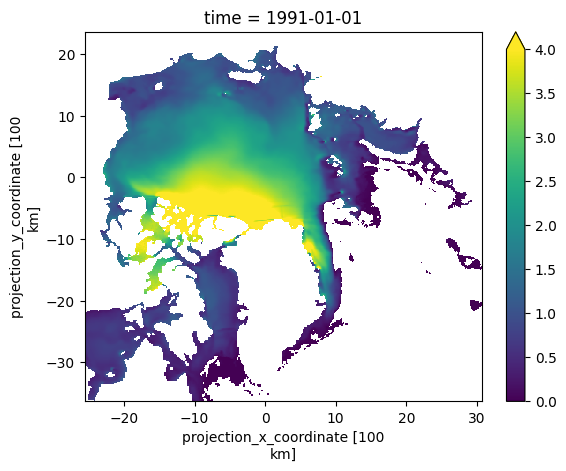

In [16]:
sit_nan.isel(time=0).plot(vmax=4)

In [17]:
sit_yearly = sit_nan.resample(time="1Y").mean(dim='time')

In [79]:
# sit_decade = sit_nan.resample(time="10Y").mean(dim='time')  # take only 1 year every 10 year

In [113]:
# Data missing in last month of 1999 and 2010 (BECAUSE OF PREDICTION - to fix)

print('\nData missing in time serie because of prediction')
print('To FIX! + be careful because dates for decade average are hardcoded')

decade0 = slice(None, 3609)
decade1 = slice(3609, 7218)
decade2 = slice(7218, 10870)


Data missing in time serie because of prediction
To FIX! + be careful because dates for decade average are hardcoded


In [50]:
sit_91_01 = sit_nan.isel(time=decade0)
sit_01_11 = sit_nan.isel(time=decade1)
sit_11_21 = sit_nan.isel(time=decade2)

In [120]:
odir = '/scratch/project_465000269/edelleo1/Leo/results/bin_fig/'

Saved as: /scratch/project_465000269/edelleo1/Leo/results/bin_fig/sit_decades.png


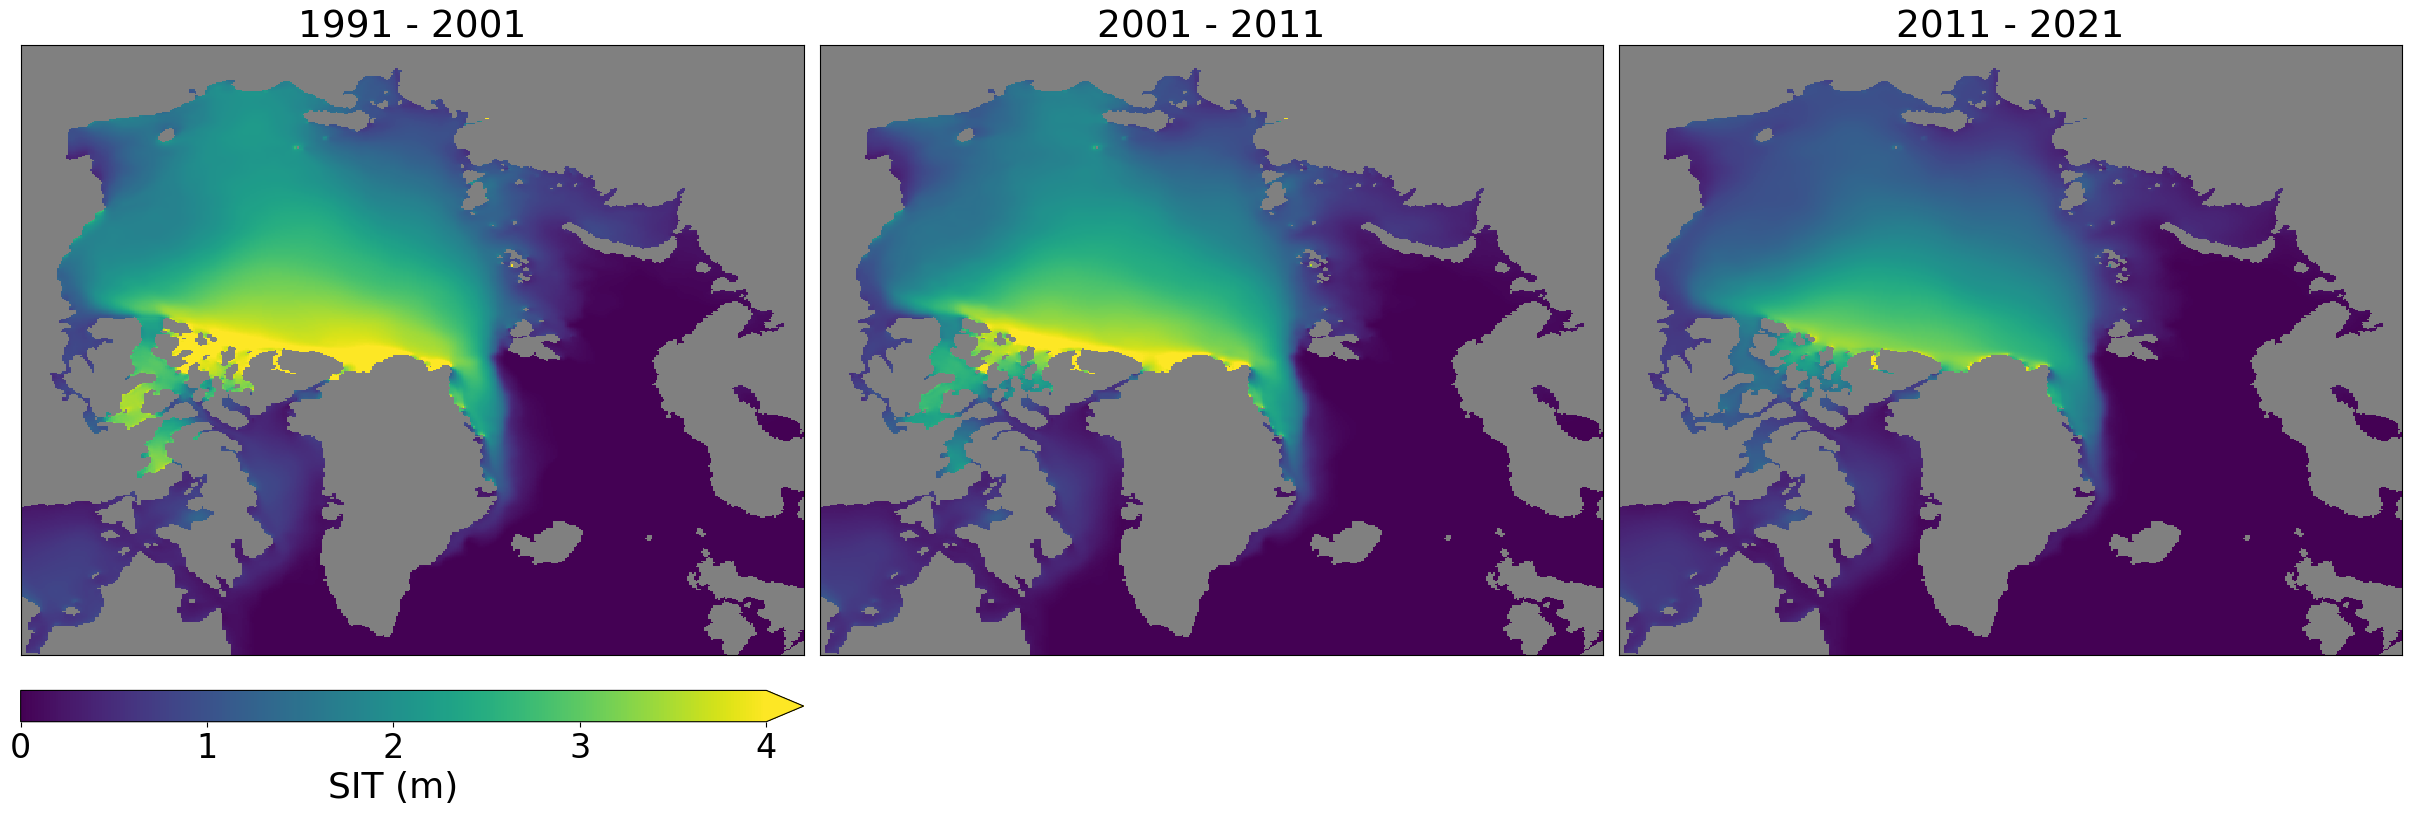

In [123]:
draw_sit_decades(sit_91_01, sit_01_11, sit_11_21, mask_ocean, odir=odir, savefig=True)

In [122]:
def draw_sit_decades(dec0, dec1, dec2, mask_ocean, odir='', savefig=False, showfig=True):
    '''Draw average 2D map of SIT for the following decades:
                1991 - 2001 01 01
                2001 - 2011 01 01
                2011 - 2023
                
    Parameters:
    -----------
    
        mask_ocean      :    to plot ocean without data in white
                
    '''
    
    fig, axes = plt.subplots(ncols=3, figsize=(8*3,8), constrained_layout=True)
    
    
    dec0_m = dec0.where((mask_ocean!=1 & np.isnan(dec0)), 0).mean('time')
    dec1_m = dec1.where((mask_ocean!=1 & np.isnan(dec1)), 0).mean('time')
    dec2_m = dec2.where((mask_ocean!=1 & np.isnan(dec2)), 0).mean('time')
    
    
    
    #fig.suptitle('RMSE of')
    dec0_m.plot(vmax=4, ax=axes[0], cbar_kwargs={'orientation':'horizontal', 'ticks':[0,1,2,3,4],
                                                                       'label':'SIT (m)', 'aspect':25})
    dec1_m.plot(vmax=4, ax=axes[1], add_colorbar=False)  #  cbar_kwargs={'orientation':'horizontal','ticks':[0,0.5,1,1.5,2],
#                                                                        'label':'RMSE (m)', 'aspect':25})
    dec2_m.plot(vmax=4, ax=axes[2], add_colorbar=False)  #cbar_kwargs={'orientation':'horizontal','ticks':[0,0.5,1,1.5,2],
#                                                                        'label':'RMSE (m)', 'aspect':25})

    axes[0].set_title('1991 - 2001')
    axes[1].set_title('2001 - 2011')
    axes[2].set_title('2011 - 2021')
    
    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)     
        ax.set_facecolor('grey')


    modif_plot.resize(fig, s=24)
    
    if savefig:
        filename = f'sit_decades.png'
        plt.savefig(f"{odir}{filename}", dpi=200, facecolor='white')
        print(f'Saved as: {odir}{filename}')
    
    if showfig:
        plt.show()
    
    plt.close()

In [38]:
sit_yearly.mean(dim=('x','y'))

<xarray.DataArray (time: 32)>
array([1.60610889, 1.60228314, 1.62962458, 1.57568104, 1.50372413,
       1.51228292, 1.54097326, 1.59514331, 1.52120438, 1.50810836,
       1.55853841, 1.54864728, 1.50200718, 1.43578993, 1.37683394,
       1.27586474, 1.27346112, 1.26195551, 1.22183291, 1.19340698,
       1.0876368 , 1.00946336, 1.0708267 , 1.19888784, 1.18017107,
       1.07258157, 1.06114458, 1.10172175, 1.11373544, 0.9993985 ,
       0.94082815, 1.07849827])
Coordinates:
  * time     (time) datetime64[ns] 1991-12-31 1992-12-31 ... 2022-12-31

In [38]:
sit_yearly.mean(dim=('x','y'))

<xarray.DataArray (time: 32)>
array([1.60610889, 1.60228314, 1.62962458, 1.57568104, 1.50372413,
       1.51228292, 1.54097326, 1.59514331, 1.52120438, 1.50810836,
       1.55853841, 1.54864728, 1.50200718, 1.43578993, 1.37683394,
       1.27586474, 1.27346112, 1.26195551, 1.22183291, 1.19340698,
       1.0876368 , 1.00946336, 1.0708267 , 1.19888784, 1.18017107,
       1.07258157, 1.06114458, 1.10172175, 1.11373544, 0.9993985 ,
       0.94082815, 1.07849827])
Coordinates:
  * time     (time) datetime64[ns] 1991-12-31 1992-12-31 ... 2022-12-31

In [42]:
sit_monthly = sit_nan.resample(time="1MS").mean(dim='time')

In [51]:
sit_monthly.mean(dim=('x','y')).isel(time=range(9,n_months,12))

<xarray.DataArray (time: 32)>
array([1.08304455, 1.23432402, 1.04751193, 1.15267883, 1.01404477,
       1.14497405, 1.09621577, 1.16743149, 1.10622804, 1.15501196,
       1.17076718, 1.08058137, 1.03582373, 0.98886348, 0.91243778,
       0.815127  , 0.74835272, 0.73493132, 0.70870024, 0.68450601,
       0.58683727, 0.59817818, 0.66058386, 0.69885066, 0.63151558,
       0.59901508, 0.59928479, 0.61865751, 0.61156236, 0.53162395,
       0.53914667, 0.56866482])
Coordinates:
  * time     (time) datetime64[ns] 1991-10-01 1992-10-01 ... 2022-10-01

### for comparison with Kwok 2018: in volume

Average of February and March from 2004 to 2018

In [67]:
idx_feb_mar = np.sort(np.concatenate((np.arange(1,n_months,12), np.arange(2,n_months,12))))

In [93]:
vol_feb = vol_monthly.isel(time=np.arange(1,n_months,12))

In [94]:
vol_mar = vol_monthly.isel(time=np.arange(2,n_months,12))

In [95]:
vol_feb.isel(time=slice(13,28))  # for comparison with Kwok 2018

<xarray.DataArray (time: 15)>
array([19796.80388412, 20005.32283977, 18717.12616153, 18041.83210165,
       17863.67679392, 17693.37264758, 16891.07230589, 16163.30895119,
       15174.80932607, 15190.09618191, 16909.62108953, 17755.04991872,
       15583.74964319, 15561.53144693, 15491.03037401])
Coordinates:
  * time     (time) datetime64[ns] 2004-02-01 2005-02-01 ... 2018-02-01
Attributes:
    name:           Sea ice volume
    description:    Sea Ice Thickness * area of original grid
    units:          km³
    standard_name:  Volume

In [96]:
vol_mar.isel(time=slice(13,28))  # for comparison with Kwok 2018

<xarray.DataArray (time: 15)>
array([21748.71632707, 21608.53374018, 20487.46411905, 19995.1727969 ,
       19718.89973365, 19556.78543683, 18218.78105132, 18014.79011723,
       15950.12215057, 17301.56658961, 18622.16489626, 19088.8582166 ,
       17273.66887517, 17088.98755242, 17231.34977917])
Coordinates:
  * time     (time) datetime64[ns] 2004-03-01 2005-03-01 ... 2018-03-01
Attributes:
    name:           Sea ice volume
    description:    Sea Ice Thickness * area of original grid
    units:          km³
    standard_name:  Volume

In [97]:
np.mean([19796.8,21748.7])

20772.75

In [98]:
np.mean([15491,17231])

16361.0

In [99]:
20772.75-16361

4411.75

In [100]:
44117.5/15

2941.1666666666665

Average of February and March over 1991-2022

In [101]:
vol_feb

<xarray.DataArray (time: 32)>
array([22845.80397207, 22098.98391548, 23148.96156787, 22196.09121081,
       21728.10606241, 21336.55738152, 21586.22413731, 22171.84936285,
       20706.86305038, 20780.79013126, 21187.44115397, 22171.58402734,
       20997.72883857, 19796.80388412, 20005.32283977, 18717.12616153,
       18041.83210165, 17863.67679392, 17693.37264758, 16891.07230589,
       16163.30895119, 15174.80932607, 15190.09618191, 16909.62108953,
       17755.04991872, 15583.74964319, 15561.53144693, 15491.03037401,
       16201.96551829, 14559.1594652 , 12953.2711195 , 14763.99652153])
Coordinates:
  * time     (time) datetime64[ns] 1991-02-01 1992-02-01 ... 2022-02-01
Attributes:
    name:           Sea ice volume
    description:    Sea Ice Thickness * area of original grid
    units:          km³
    standard_name:  Volume

In [102]:
vol_mar

<xarray.DataArray (time: 32)>
array([24264.81224073, 23845.87466896, 24847.05065988, 24150.84249268,
       22792.27934242, 22927.91126575, 23302.71142434, 24071.99642563,
       22404.60747527, 22116.63072234, 22864.51768303, 24454.01976516,
       23172.40446018, 21748.71632707, 21608.53374018, 20487.46411905,
       19995.1727969 , 19718.89973365, 19556.78543683, 18218.78105132,
       18014.79011723, 15950.12215057, 17301.56658961, 18622.16489626,
       19088.8582166 , 17273.66887517, 17088.98755242, 17231.34977917,
       17948.9691209 , 16890.99994201, 14865.86272755, 16608.47509497])
Coordinates:
  * time     (time) datetime64[ns] 1991-03-01 1992-03-01 ... 2022-03-01
Attributes:
    name:           Sea ice volume
    description:    Sea Ice Thickness * area of original grid
    units:          km³
    standard_name:  Volume

-------------------

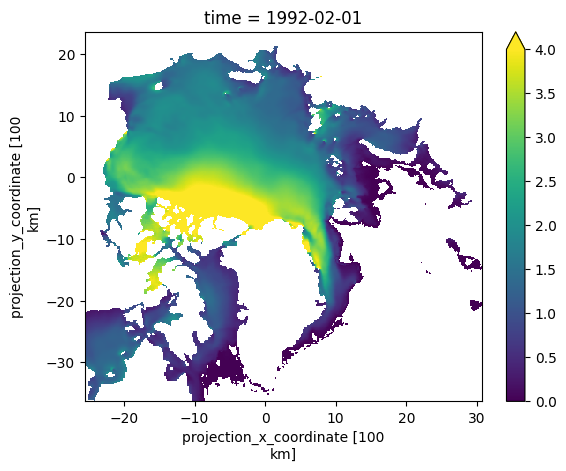

In [70]:
sit_monthly.isel(time=idx_feb_mar).isel(time=2).plot(vmax=4)

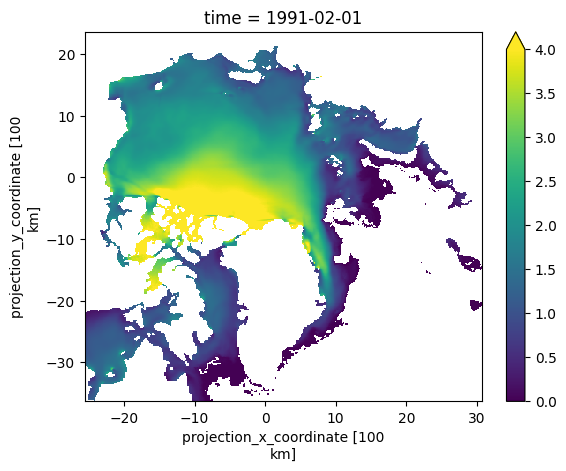

In [58]:
sit_monthly.isel(time=range(1,n_months,12)).isel(time=0).plot(vmax=4)

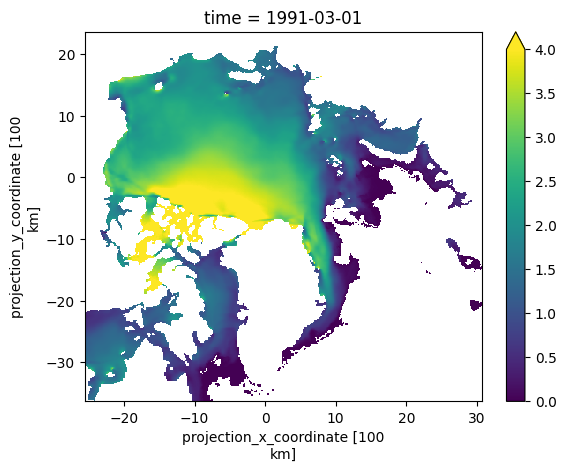

In [59]:
sit_monthly.isel(time=range(2,n_months,12)).isel(time=0).plot(vmax=4)

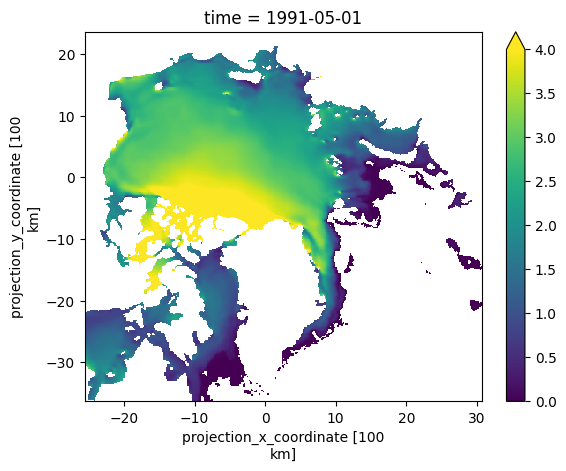

In [46]:
sit_monthly.isel(time=range(4,n_months,12)).isel(time=0).plot(vmax=4)

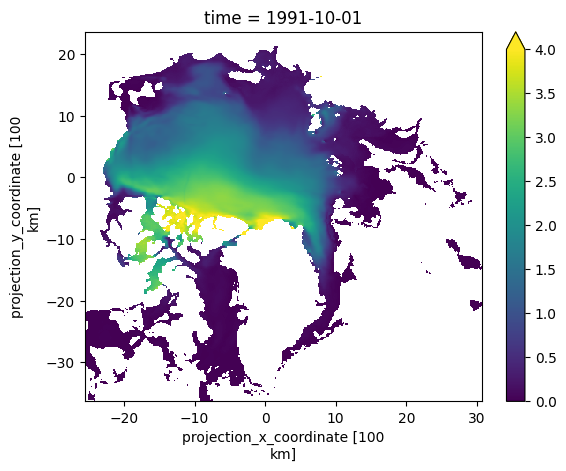

In [47]:
sit_monthly.isel(time=range(9,n_months,12)).isel(time=0).plot(vmax=4)

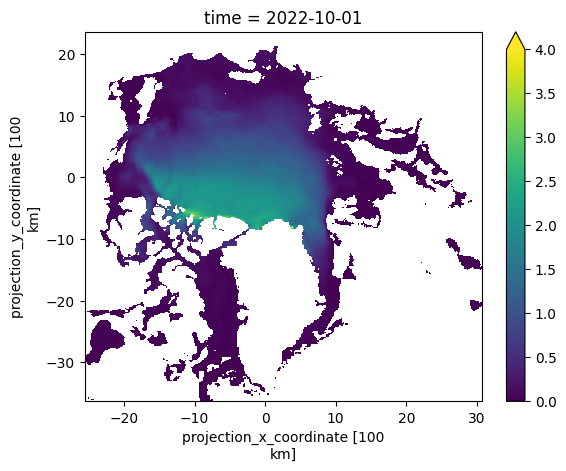

In [48]:
sit_monthly.isel(time=range(9,n_months,12)).isel(time=-1).plot(vmax=4)

# Compute sea ice volume (SIT*area)

In [16]:
# Repeat area on time axis - not needed
# area_t = area[np.newaxis,:,:].repeat(len(sit_nan.time), axis=0)

In [17]:
volume = np.nansum(sit_nan * area, axis=(1,2)) / 1e9

# Nice variable for volume

In [18]:
xr_vol = xr.DataArray(
    data=volume,
    dims=["time"],
    coords=dict(
        time=(["time"], sit_nan.time.data)    #   <---- or sit_ml
    ),
    attrs=dict(
        name="Sea ice volume",
        description="Sea Ice Thickness * area of original grid",
        units="km³",
        standard_name='Volume',
    ),
)

## Min (Octobre) / Max (May)

In [19]:
vol_monthly = xr_vol.resample(time="1MS").mean(dim='time')

In [20]:
n_months = len(vol_monthly)

In [21]:
vol_monthly.isel(time=range(4,n_months,12))

<xarray.DataArray (time: 32)>
array([26605.07483954, 25649.43640566, 26805.50656327, 26082.26884616,
       25209.76492482, 24558.23053442, 25224.47828823, 25444.88375801,
       24963.55002597, 23860.98131017, 24528.17801396, 26049.52322521,
       24873.45698028, 23342.07587993, 23244.60063518, 21043.33081245,
       21682.48068496, 21815.06963798, 21095.76295609, 19707.49854749,
       19144.63674666, 17457.34591747, 18417.84997453, 20352.10645705,
       20379.83154207, 18498.30076822, 18306.29488312, 18781.25614081,
       19541.21131823, 18378.58489729, 16279.30152947, 18803.55239009])
Coordinates:
  * time     (time) datetime64[ns] 1991-05-01 1992-05-01 ... 2022-05-01
Attributes:
    name:           Sea ice volume
    description:    Sea Ice Thickness * area of original grid
    units:          km³
    standard_name:  Volume

In [22]:
vol_monthly.isel(time=range(9,n_months,12))

<xarray.DataArray (time: 32)>
array([12574.49545814, 13755.58878689, 12770.08621529, 12696.92135659,
       11518.09958231, 12607.79612932, 12823.46594525, 13419.72345482,
       12926.21146322, 13302.44060408, 13503.94601687, 12203.60102323,
       11603.62941517, 11669.8298119 , 10534.51886765,  9668.80033205,
        8794.46614897,  8361.32911934,  8041.90012486,  7464.87293615,
        6807.13298606,  6347.79205804,  7291.78851713,  8224.42600816,
        7381.52851743,  6248.87784094,  6718.12100001,  6603.23200545,
        6189.42913778,  5130.66149762,  5544.19885158,  6258.19025778])
Coordinates:
  * time     (time) datetime64[ns] 1991-10-01 1992-10-01 ... 2022-10-01
Attributes:
    name:           Sea ice volume
    description:    Sea Ice Thickness * area of original grid
    units:          km³
    standard_name:  Volume

## Yearly average

Just to read the correct amount of average volume over the years

In [21]:
vol_yearly = xr_vol.resample(time="1Y").mean(dim='time')

In [22]:
vol_yearly

<xarray.DataArray (time: 32)>
array([19688.48135817, 19873.00853204, 20246.01270149, 19455.23735003,
       18589.89960462, 18829.69052362, 19212.67050582, 19797.31736751,
       18920.52454774, 18620.51449246, 19301.04970501, 19259.55672204,
       18627.00660192, 17897.14740577, 16898.80722709, 15680.72027177,
       15659.18727751, 15474.57036356, 14996.92711558, 14399.00816225,
       13232.7838695 , 12033.00278165, 12902.56110187, 14654.63253315,
       14356.35461651, 12784.4963547 , 12802.49330804, 13158.39299578,
       13159.13248434, 11700.26175448, 10953.84051463, 12699.85288264])
Coordinates:
  * time     (time) datetime64[ns] 1991-12-31 1992-12-31 ... 2022-12-31
Attributes:
    name:           Sea ice volume
    description:    Sea Ice Thickness * area of original grid
    units:          km³
    standard_name:  Volume

# Compute trends

In [23]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats

In [24]:
# function which compute the indexes of 2 days
# returns the slope of the linear regression, with p value

In [47]:
def linreg(xr_vol, date_1, date_2):
    '''
    Parameters:
    -----------
    
        xr_vol    :     xarray.DataArray, sea ice volume, average over the Arctic. dimension: 'time'
    '''
    # identify index to plot
    chrono_tp = pd.DataFrame({'date':pd.to_datetime(xr_vol.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono_tp.date])
    idx_1 = np.where(chrono_dt==date_1.date())[0]
    idx_2 = np.where(chrono_dt==date_2.date())[0]
    
    ## if date not found:
    if len(idx_1) > 0:  ## date found in time axis
        idx_1 = idx_1[0]
    else:
        # import pdb; pdb.set_trace()
        return None, None, None, None, None
    if len(idx_2) > 0:  ## date found in time axis
        idx_2 = idx_2[0]
    else:
        return None, None, None, None, None
    
    ## Inputs of linear regression
    nt = np.arange(len(xr_vol.time))
    lr_vol = xr_vol.isel(time=slice(idx_1, idx_2)).to_numpy()
    lr_time = nt[idx_1:idx_2]

    m1 = LinearRegression().fit(lr_time.reshape(-1,1), lr_vol)  ## fit

    ## Prediction
    new_x = nt[idx_1:idx_2].reshape(-1,1)  ## for prediction
    new_time = xr_vol.time[idx_1:idx_2]  ## for plot
    y_pred = m1.predict(new_x)

    ## just to get p-value
    slope, intercept, r_val, p_val, std_err = stats.linregress(lr_time, lr_vol)

    # return line to plot X, Y, slope coefficient, p value, nt (number of time steps)
    return new_time, y_pred, slope, p_val, nt

In [24]:
# Demo for 1 period

#day_1 = datetime.datetime(2014,1,1)
#day_2 = datetime.datetime(2016,1,1)
#
#new_t, y_pp, sslope, ppval = linreg(xr_vol, day_1, day_2)
#
#plt.plot(new_t, y_pp)

## Loop for several time period

In [26]:
## Create dictionnary for several trends

dates_trends = [datetime.datetime(1991,1,1), datetime.datetime(2022,11,1)]

# dates_trends = [datetime.datetime(1991,1,1), datetime.datetime(2022,11,1), 
#                 datetime.datetime(1991,1,1), datetime.datetime(2002,1,1), 
#                 datetime.datetime(2002,1,1), datetime.datetime(2013,1,1), 
#                 datetime.datetime(2013,1,1), datetime.datetime(2022,11,1)]

trends = {}

for tr in range(len(dates_trends)//2):
    new_t, y_pp, sslope, ppval, nt =  linreg(xr_vol, dates_trends[tr*2], dates_trends[tr*2+1])
    if new_t is not None:
        trends[tr] = (new_t, y_pp, sslope, ppval, dates_trends[tr*2], dates_trends[tr*2+1], nt)

In [37]:
trends.keys()

dict_keys([0])

## Trends for min and max

Same function, only use first day of each month

In [28]:
## Create dictionnary for several trends

dates_trends = [datetime.datetime(1991,10,1), datetime.datetime(2022,10,1)]

# dates_trends = [datetime.datetime(1991,10,1), datetime.datetime(2022,10,1), 
#                 datetime.datetime(1991,10,1), datetime.datetime(2003,10,1), 
#                 datetime.datetime(2002,10,1), datetime.datetime(2013,10,1), 
#                 datetime.datetime(2013,10,1), datetime.datetime(2022,10,1)]

trends_min = {}

for tr in range(len(dates_trends)//2):
    new_t, y_pp, sslope, ppval, nt =  linreg(vol_monthly.isel(time=range(9,n_months,12)), dates_trends[tr*2], dates_trends[tr*2+1])
    if new_t is not None:
        trends_min[tr] = (new_t, y_pp, sslope, ppval, dates_trends[tr*2], dates_trends[tr*2+1], nt)

In [29]:
## Create dictionnary for several trends

dates_trends = [datetime.datetime(1991,5,1), datetime.datetime(2022,5,1)]

# dates_trends = [datetime.datetime(1991,5,1), datetime.datetime(2022,5,1), 
#                 datetime.datetime(1991,5,1), datetime.datetime(2002,5,1), 
#                 datetime.datetime(2002,5,1), datetime.datetime(2013,5,1), 
#                 datetime.datetime(2013,5,1), datetime.datetime(2022,5,1)]
# 
trends_max = {}

for tr in range(len(dates_trends)//2):
    new_t, y_pp, sslope, ppval, nt =  linreg(vol_monthly.isel(time=range(4,n_months,12)), dates_trends[tr*2], dates_trends[tr*2+1])
    if new_t is not None:
        trends_max[tr] = (new_t, y_pp, sslope, ppval, dates_trends[tr*2], dates_trends[tr*2+1], nt)

# Plot SIV

In [60]:
def draw_vol(vol, volm, trends={}, trends_min={}, trends_max={}, odir='', showfig=True, savefig=False):
    '''
    Parameters:
    -----------
    
        vol    :    xarray.DataArray, daily volume 
        volm   :    xarray.DataArray, volume average each month
        trends :    dictionnary, contains trends to plot
    '''
    
    fig, ax = plt.subplots(figsize=(16,9), constrained_layout=True)

    ## Draw volume
    (volm/1000).isel(time=range(4,n_months,12)).plot(ms=15, lw=2, marker='.', color='b', label='May')
    (volm/1000).isel(time=range(9,n_months,12)).plot(ms=15, lw=2, marker='.', color='r', label='October')
    (vol/1000).plot(lw=2, color='k')

    ## Draw trends
    list_trends = list(trends.keys())
    if len(list_trends)>0:
        for n in list_trends:
            plt.plot(trends[n][0], trends[n][1]/1000, c='k', ls='--')
        
    list_trends_min = list(trends_min.keys())
    if len(list_trends_min)>0:
        for n in list_trends_min:
            plt.plot(trends_min[n][0], trends_min[n][1]/1000, c='r', ls='--', marker='+', ms=10)
        
    list_trends_max = list(trends_max.keys())
    if len(list_trends_max)>0:
        for n in list_trends_max:
            plt.plot(trends_max[n][0], trends_max[n][1]/1000, c='b', ls='--', marker='+', ms=10)
        
      
    ax.yaxis.grid(alpha=0.6, ls='-.')
    ax.xaxis.grid(alpha=0.6)
    ax.set_ylabel('Sea Ice Volume (1000 km³)')
    ax.set_xlabel('')
    ax.spines[['right', 'top']].set_visible(False)

    plt.legend(fontsize=18)

    ax.set_xlim([datetime.datetime(1991,1,1), datetime.datetime(2022,12,31)])
    
    modif_plot.resize(fig, s=24)

    if savefig:
        ofile = f'SIV_01.png'
        ofile = save_name.check(odir, ofile)
        plt.savefig(f"{odir}{ofile}", dpi=200, facecolor='white')
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()

    plt.close()    


In [30]:
odir = f'{rootdir}Leo/results/bin_fig/'

Saved as: /scratch/project_465000269/edelleo1/Leo/results/bin_fig/SIV_03.png


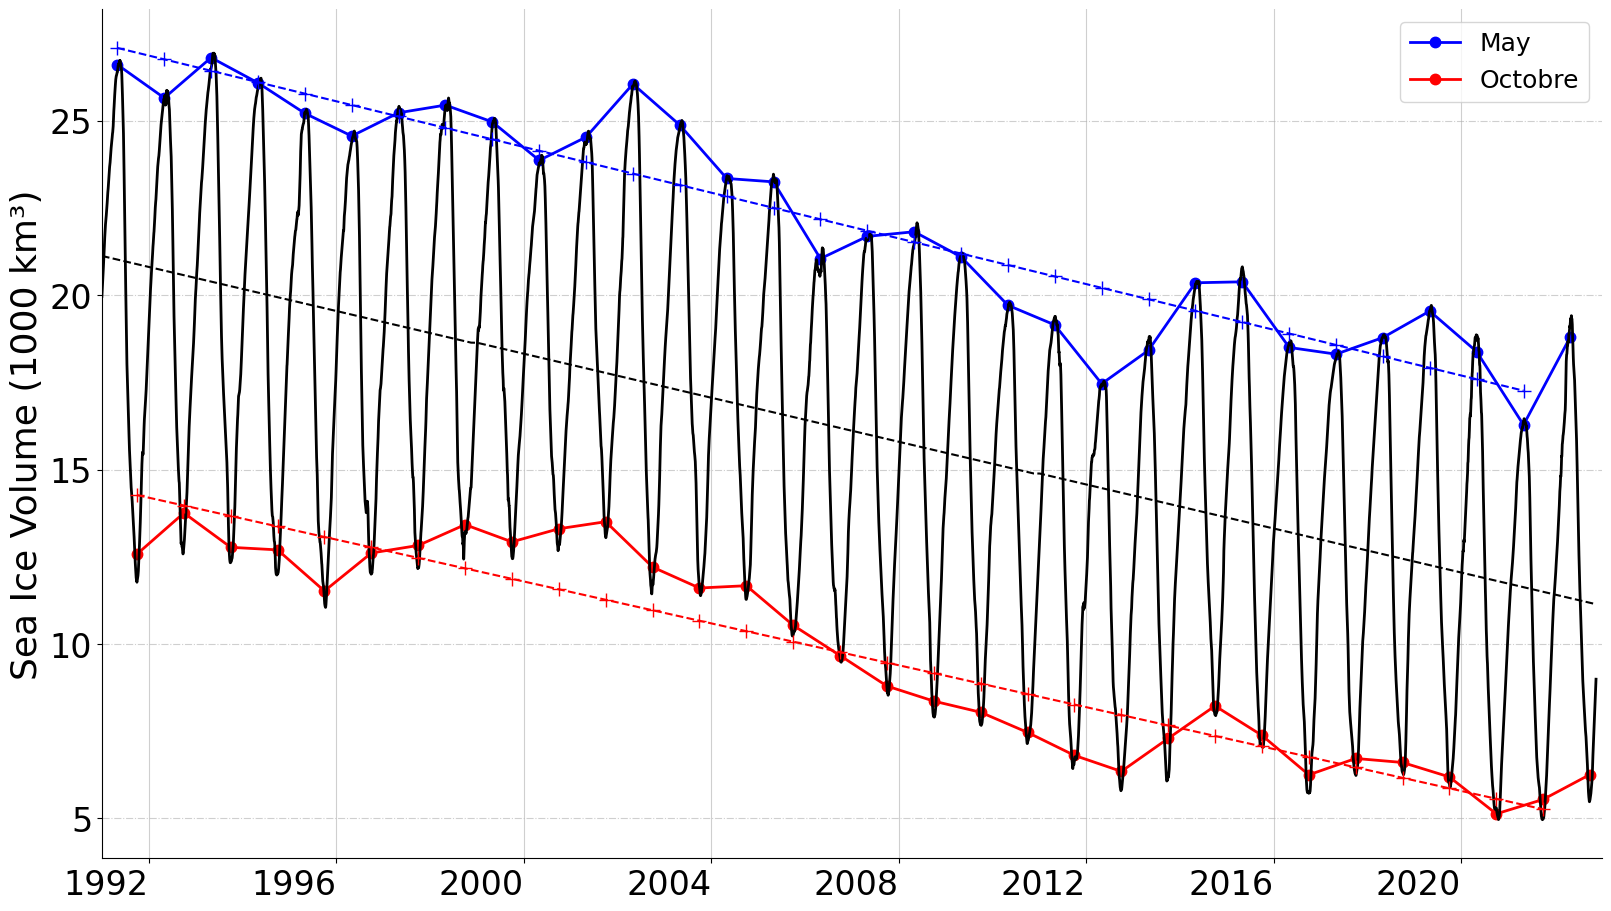

In [61]:
draw_vol(xr_vol, vol_monthly, trends=trends, trends_min=trends_min, trends_max=trends_max, odir=odir, savefig=True)

In [32]:
# monthly trends
print(trends_min[0][2],' km3 per year')
print(trends_min[0][2]*10, 'km3 per decade')

-300.18350018474354  km3 per year
-3001.8350018474353 km3 per decade


In [33]:
# monthly trends
print(trends_max[0][2],' km3 per year')
print(trends_max[0][2]*10, ' km3 per decade')

-327.4535286016444  km3 per year
-3274.535286016444  km3 per decade


In [34]:
# monthly trends
print(trends[0][2],' km3 per day')
print(trends[0][2]*365,' km3 per yr')
print(trends[0][2]*365*10, ' km3 per decade')

-0.8638722995597697  km3 per day
-315.31338933931596  km3 per yr
-3153.1338933931597  km3 per decade
